In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
image_path = "/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset"
dir_Flickr_text = "/content/gdrive/MyDrive/Flickr8k/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']


uni_filenames = np.unique(data.filename.values)
data.head()

index  ...                                            caption
0     0  ...  a child in a pink dress is climbing up a set o...
1     1  ...              a girl going into a wooden building .
2     2  ...   a little girl climbing into a wooden playhouse .
3     3  ...  a little girl climbing the stairs to her playh...
4     4  ...  a little girl in a pink dress going into a woo...

[5 rows x 3 columns]

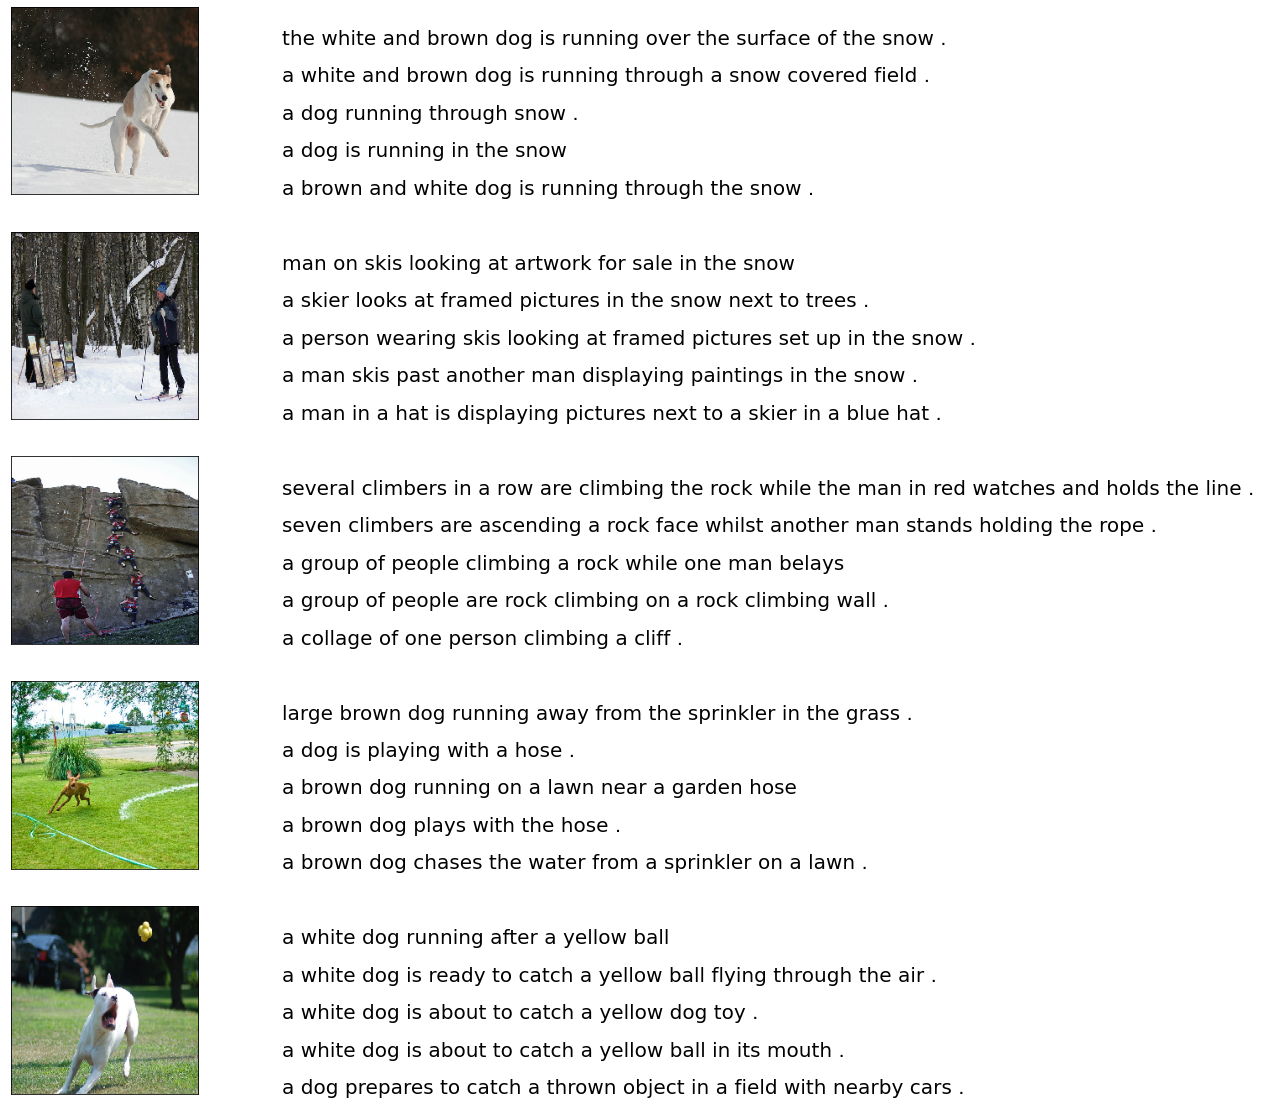

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [ ]:
img = data["filename"].tolist()
caption = data["caption"].tolist()

In [ ]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

len(img) : 40455
len(caption) : 40455


In [ ]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [ ]:
PATH = "/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/Flickr8k/Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [ ]:
train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [ ]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 40000
len(all_captions) : 40000


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())



  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 1/506 [00:00<04:13,  1.99it/s]

  0%|          | 2/506 [00:00<03:50,  2.18it/s]

  1%|          | 3/506 [00:01<03:32,  2.37it/s]

  1%|          | 4/506 [00:01<03:19,  2.51it/s]

  1%|          | 5/506 [00:01<03:14,  2.57it/s]

  1%|          | 6/506 [00:02<02:56,  2.83it/s]

  1%|▏         | 7/506 [00:02<03:47,  2.20it/s]

  2%|▏         | 8/506 [00:03<03:42,  2.24it/s]

  2%|▏         | 9/506 [00:03<03:34,  2.32it/s]

  2%|▏         | 10/506 [00:04<03:32,  2.34it/s]

  2%|▏         | 11/506 [00:04<03:28,  2.38it/s]

  2%|▏         | 12/506 [00:04<03:25,  2.40it/s]

  3%|▎         | 13/506 [00:05<03:21,  2.45it/s]

  3%|▎         | 14/506 [00:05<03:37,  2.26it/s]

  3%|▎         | 15/506 [00:06<03:20,  2.45it/s]

  3%|▎         | 16/506 [00:06<03:17,  2.48it/s]

  3%|▎         | 17/506 [00:06<03:00,  2.70it/s]

  4%|▎         | 18/506 [00:07<03:05,  2.63it/s]

  4%|▍         | 19/506 [00:07<03:00,  2.70it/s]

  4%|▍         |

### Preprocess and tokenize the captions

In [ ]:
top_k = 5000

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector.shape

(40000, 33)

### Split the data into training and testing

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

### Create a tf.data dataset for training

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):


  matmul_qk = tf.matmul(q, k, transpose_b=True)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [ ]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [ ]:
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  dec_mask = create_masks_decoder(tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp,
                                 True,
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(30):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))


  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1121 Accuracy 0.1543
Epoch 1 Batch 50 Loss 2.1148 Accuracy 0.1498
Epoch 1 Batch 100 Loss 2.1104 Accuracy 0.1505
Epoch 1 Batch 150 Loss 2.1048 Accuracy 0.1501
Epoch 1 Batch 200 Loss 2.1005 Accuracy 0.1499
Epoch 1 Batch 250 Loss 2.0993 Accuracy 0.1497
Epoch 1 Batch 300 Loss 2.0963 Accuracy 0.1500
Epoch 1 Batch 350 Loss 2.0921 Accuracy 0.1502
Epoch 1 Batch 400 Loss 2.0860 Accuracy 0.1504
Epoch 1 Batch 450 Loss 2.0807 Accuracy 0.1506
Epoch 1 Loss 2.0768 Accuracy 0.1507
Time taken for 1 epoch: 123.2374176979065 secs

Epoch 2 Batch 0 Loss 2.0040 Accuracy 0.1455
Epoch 2 Batch 50 Loss 2.0277 Accuracy 0.1524
Epoch 2 Batch 100 Loss 2.0238 Accuracy 0.1540
Epoch 2 Batch 150 Loss 2.0196 Accuracy 0.1538
Epoch 2 Batch 200 Loss 2.0152 Accuracy 0.1535
Epoch 2 Batch 250 Loss 2.0114 Accuracy 0.1538
Epoch 2 Batch 300 Loss 2.0097 Accuracy 0.1542
Epoch 2 Batch 350 Loss 2.0061 Accuracy 0.1542
Epoch 2 Batch 400 Loss 2.0012 Accuracy 0.1542
Epoch 2 Batch 450 Loss 1.9966 Accuracy 0.1544
Ep

In [ ]:
transformer.save_weights('image_caption_transformer_45.h5')

In [ ]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']

  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)

      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)

      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 38.94003915357025
BLEU-2 score: 55.06953149031838
BLEU-3 score: 63.25828023338613
BLEU-4 score: 65.48907866815301
Real Caption: dog leaps to catch ball
Predicted Caption: dog catches ball outside


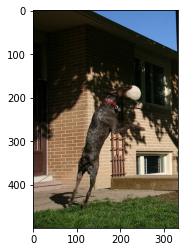

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 37.5
BLEU-2 score: 61.237243569579455
BLEU-3 score: 74.5091107671223
BLEU-4 score: 78.25422900366436
Real Caption: young girl is playing in fountain of water
Predicted Caption: young boy plays in the water without shirt


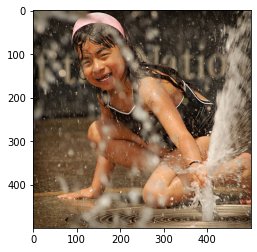

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 33.33333333333333
BLEU-2 score: 57.735026918962575
BLEU-3 score: 71.92230933248644
BLEU-4 score: 75.98356856515926
Real Caption: dog standing outside is looking at the camera
Predicted Caption: tan and white dog is running through the leaves


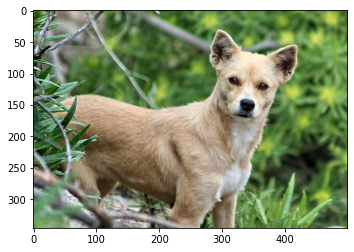

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 22.22222222222222
BLEU-2 score: 47.14045207910317
BLEU-3 score: 63.684866956664344
BLEU-4 score: 68.65890479690393
Real Caption: group of men stand outside glass and steel building
Predicted Caption: three people are standing outside of an outdoor ticket


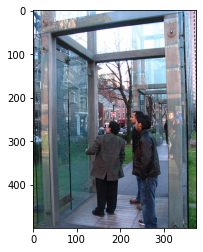

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


In [ ]:
!pip install ultralytics wikipedia-api # Install the latest YOLOv8 package

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14346 sha256=41199559a6baac1fa5e6797dfe45f0ee7eeddf22127b9429a95d88e818029e9f
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api


In [ ]:
from pathlib import Path
from IPython.display import Image as IPImage, display
import torch

# Load YOLOv5 model (e.g., YOLOv5s for small model)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-11-13 Python-3.10.12 torch-2.5.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 169MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


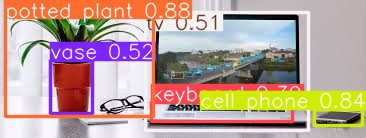

Detected objects: ['potted plant', 'cell phone', 'vase', 'tv', 'keyboard']


In [ ]:
IMAGE_PATH = '/content/compute.jpg'  # Path to your image
results = model(IMAGE_PATH)

# Display results
results.show()

# Get detected object names
detected_objects = results.pandas().xyxy[0]['name'].tolist()
print(f"Detected objects: {detected_objects}")

In [ ]:
import wikipediaapi
def get_wikipedia_summary(query, language='english'):
    wiki_wiki = wikipediaapi.Wikipedia(language)
    page = wiki_wiki.page(query)

    if page.exists():
        return page.summary
    else:
        return "No information found on Wikipedia."

# Example usage
object_name = "Eiffel Tower"
summary = get_wikipedia_summary(object_name)
print(summary)

The Eiffel Tower (  EYE-fəl; French: Tour Eiffel [tuʁ ɛfɛl] ) is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower from 1887 to 1889.
Locally nicknamed "La dame de fer" (French for "Iron Lady"), it was constructed as the centerpiece of the 1889 World's Fair, and to crown the centennial anniversary of the French Revolution. Although initially criticised by some of France's leading artists and intellectuals for its design, it has since become a global cultural icon of France and one of the most recognisable structures in the world. The tower received 5,889,000 visitors in 2022. The Eiffel Tower is the most visited monument with an entrance fee in the world: 6.91 million people ascended it in 2015. It was designated a monument historique in 1964, and was named part of a UNESCO World Heritage Site ("Paris, Banks of the Seine") in 1991.
The tower is 330 metres (1,083 ft) tall, about t

In [ ]:
summary = []
for objects in detected_objects:
    summary.append(get_wikipedia_summary(objects))
print(summary)


['Container gardening or pot gardening/farming is the practice of growing plants, including edible plants, exclusively in containers instead of planting them in the ground.  A container in gardening is a small, enclosed and usually portable object used for displaying live flowers or plants. It may take the form of a pot, box, tub, basket, tin, barrel or hanging basket.', 'A mobile phone or cell phone is a portable telephone that can make and receive calls over a radio frequency link while the user is moving within a telephone service area, as opposed to a fixed-location phone (landline phone). The radio frequency link establishes a connection to the switching systems of a mobile phone operator, which provides access to the public switched telephone network (PSTN). Modern mobile telephone services use a cellular network architecture, and therefore mobile telephones are called cellphones (or "cell phones") in North America. In addition to telephony, digital mobile phones support a variet

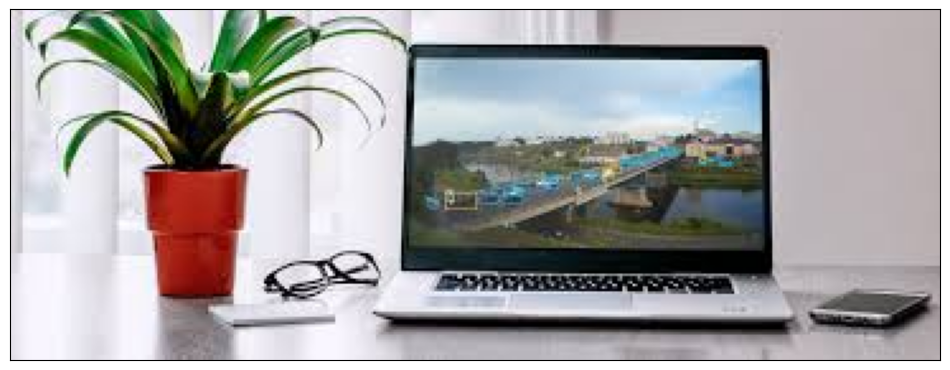

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
image = plt.imread('/content/compute.jpg')
width, height = image.shape[1], image.shape[0]
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

In [ ]:
import os
from PIL import Image
import torch
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel, BlipProcessor, BlipForConditionalGeneration

In [ ]:
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def encode_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = resnet_model(image_tensor)
    return features.squeeze()

image_features = encode_image(IMAGE_PATH)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_model = BertModel.from_pretrained("bert-base-uncased")
text_model.eval()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Example text
text = "A dog playing in the park."

sum = " ".join(summary)
# Tokenize and get embeddings
inputs = tokenizer(sum, return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    outputs = model(**inputs)

# Get the embeddings from the last hidden state (mean of all tokens)
text_embedding = outputs.last_hidden_state.mean(dim=1)  # (1, 768)
print(text_embedding.shape)  # Should be (1, 768)


torch.Size([1, 768])


In [ ]:
text_features = text_embedding[0]

In [ ]:
print(text_features)
print(image_features)

tensor([-1.70758e-01,  1.54578e-01,  3.51507e-01, -1.17790e-01,  3.14875e-01,  1.72636e-01, -2.09738e-02,  4.34638e-01,  8.87756e-02,  4.75419e-02, -3.19210e-01, -4.16679e-01, -3.37798e-01,  2.86221e-01, -8.73947e-02,  3.43469e-01,  3.97098e-01,  2.05641e-01, -2.71126e-01,  4.58343e-01, -2.83550e-02,  9.64553e-02,
         9.20199e-02,  5.73414e-01,  3.26349e-01, -1.42563e-01, -4.26431e-02,  1.30516e-01, -9.10807e-02, -2.19027e-01,  7.48454e-01,  8.41994e-03, -1.06544e-01, -2.66060e-01,  2.81308e-01, -1.73626e-01, -1.48386e-01, -4.41914e-01, -1.79696e-01,  2.47431e-02, -6.74904e-01, -5.05077e-01,  3.75469e-02,  9.55410e-02,
        -1.68102e-01,  2.09369e-02,  3.20462e-01,  1.29207e-01, -2.05975e-01,  3.13847e-01, -6.72302e-01,  2.52090e-01, -1.94297e-01,  9.72324e-02,  3.79322e-01,  6.22469e-01, -1.40124e-02, -4.38108e-01, -4.69383e-01, -3.07806e-01, -3.26358e-01,  1.51583e-01,  2.97287e-02, -5.08061e-01,  1.71875e-01, -2.90140e-02,
         4.02820e-02,  4.19445e-01, -6.91974e-01, -2

In [ ]:
combined_embedding = torch.cat((text_features,image_features))
print(combined_embedding.shape)

torch.Size([1768])


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


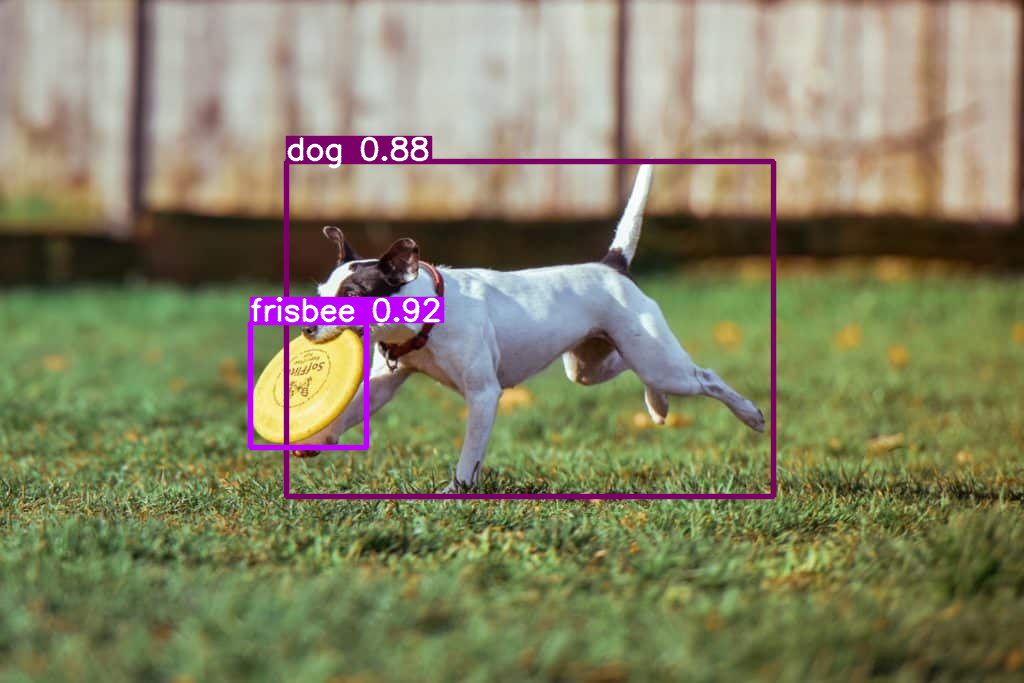

Detected objects: ['frisbee', 'dog']


In [ ]:
IMAGE_PATH = '/content/dog.jpg'  # Path to your image
results = model(IMAGE_PATH)

# Display results
results.show()

# Get detected object names
detected_objects = results.pandas().xyxy[0]['name'].tolist()
print(f"Detected objects: {detected_objects}")

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, CLIPProcessor, CLIPModel
from PIL import Image
import torch

# Load models and processors
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Load image and detected objects
image_path = "/content/dog.jpg"  # Replace with the path to your image
detected_objects = ["dog", "Frisbee", "park"]

# Manually limit external knowledge to key points
wiki_summary = "Frisbees are used in dog sports and for recreational play in parks."

# Step 1: Encode image with CLIP
image = Image.open(image_path)
image_inputs = clip_processor(images=image, return_tensors="pt")
image_features = clip_model.get_image_features(**image_inputs)

# Step 2: Refine prompt with scene details
text_input = f"A dog is playing with a Frisbee in the park. {wiki_summary}"

# Tokenize prompt for T5
text_inputs = t5_tokenizer(text_input, return_tensors="pt", padding=True, truncation=True)

# Generate caption/answer
output = t5_model.generate(input_ids=text_inputs.input_ids, max_length=50)
caption = t5_tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Caption:", caption)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generated Caption: A dog is playing with a Frisbee in the park.


In [ ]:
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

x = load_img('Data/xian.jpg', target_size=(YOLO3.width, YOLO3.height))
x = img_to_array(x) / 255
x = np.expand_dims(x, axis=0)
y = model.predict(x)

In [ ]:
boxes = decode_predictions(y, width, height)

for box in boxes:
    print(f'({box.xmin}, {box.ymin}), ({box.xmax}, {box.ymax}), {box.label}, {box.score}')

(692, 232), (1303, 1490), person, 0.9970048069953918
(1314, 327), (1920, 1496), person, 0.9957388639450073
(716, 786), (1277, 1634), bicycle, 0.9924144744873047
(1210, 845), (2397, 1600), bicycle, 0.9957170486450195


In [ ]:
x = load_img('Data/abby-lady.jpg', target_size=(YOLO3.width, YOLO3.height))
x = img_to_array(x) / 255
x = np.expand_dims(x, axis=0)
y = model.predict(x)

In [ ]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
from langchain_community.llms import Ollama
llm = Ollama(model="llama2")

<ipython-input-6-5f60b5ae5ce8>:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama2")


In [ ]:
llm.invoke("hello who are you")

"\nHello! I'm LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I'm here to help answer any questions you may have or engage in a chat with you. How can I assist you today?"

In [ ]:
from pathlib import Path
from IPython.display import Image as IPImage, display
import torch

# Load YOLOv5 model (e.g., YOLOv5s for small model)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-11-13 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 183MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
WARNING ⚠️ NMS time limit 0.550s exceeded


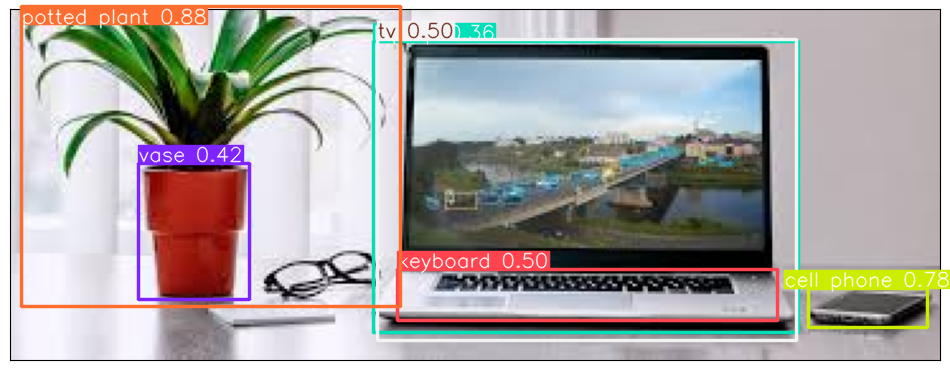

Detected objects: ['potted plant', 'cell phone', 'tv', 'keyboard', 'vase', 'laptop']


In [ ]:
IMAGE_PATH = 'testcompute.png'  # Path to your image
results = model(IMAGE_PATH)

# Display results
results.show()

# Get detected object names
detected_objects = results.pandas().xyxy[0]['name'].tolist()
print(f"Detected objects: {detected_objects}")

In [ ]:
llama_prompt = f"The following objects were detected in an image: {detected_objects}. Based on these objects, describe the likely scene and provide a detailed explanation."

llm.invoke(llama_prompt)

"\nBased on the objects detected in the image, it is likely that the scene depicts a living room or home office. Here's a detailed explanation of the possible scenario:\n\n1. Potted plant: The presence of a potted plant suggests that the scene takes place indoors, as potted plants are typically not found outdoors. It could be a houseplant, such as an aloe vera or a snake plant, which is often kept in a pot on a table or shelf.\n2. Cell phone: The fact that a cell phone is visible in the image suggests that the scene takes place in a location where people are likely to use their phones, such as a living room or home office. It could be a personal phone belonging to one of the people in the scene, or it could be a phone that belongs to someone who is not present in the image.\n3. TV: The presence of a TV in the scene indicates that the location is likely a living space, such as a living room or family room. It could be a TV that belongs to one of the people in the scene, or it could be a